# Unzip dataset

In [ ]:
!unzip augmented_dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: augmented_dataset/wa/aug_0_210.jpg  
  inflating: augmented_dataset/wa/aug_0_2064.jpg  
  inflating: augmented_dataset/wa/aug_0_3194.jpg  
  inflating: augmented_dataset/wa/aug_0_6993.jpg  
  inflating: augmented_dataset/wa/aug_0_758.jpg  
  inflating: augmented_dataset/wa/aug_0_3056.jpg  
  inflating: augmented_dataset/wa/aug_0_122.jpg  
  inflating: augmented_dataset/wa/aug_0_4647.jpg  
  inflating: augmented_dataset/wa/aug_0_4523.jpg  
  inflating: augmented_dataset/wa/aug_0_808.jpg  
  inflating: augmented_dataset/wa/aug_0_3631.jpg  
  inflating: augmented_dataset/wa/aug_0_9951.jpg  
  inflating: augmented_dataset/wa/aug_0_7231.jpg  
  inflating: augmented_dataset/wa/aug_0_6144.jpg  
  inflating: augmented_dataset/wa/aug_0_4793.jpg  
  inflating: augmented_dataset/wa/aug_0_8598.jpg  
  inflating: augmented_dataset/wa/aug_0_6236.jpg  
  inflating: augmented_dataset/wa/aug_0_1979.jpg  
  inflating: augmented_dataset/wa/a

# Import libraries

In [ ]:
import tensorflow as tf
import PIL
from matplotlib import pyplot as plt
import os
import numpy as np
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Set Constants

In [ ]:
IMG_HEIGHT = 64
IMG_WIDTH = 64
IMG_SIZE = (IMG_HEIGHT, IMG_WIDTH, 3)  # Adjust image size as per your dataset
DATA_DIR = 'augmented_dataset'
NUM_CLASSES = 18  # Number of classes
VALIDATION_SPLIT = 0.2  # 20% validation split
SEED = 42
BATCH_SIZE = 32   # Global batch size

# Visualization Tools

In [ ]:
def visualize_data(dataset, label_class, num_images=5):
  """Visualizes images, labels, and bounding boxes from the dataset.

  Args:
    dataset: The  dataset.
    num_images: The number of images to visualize.
  """
  plt.figure(figsize=(15, 5))

  # Iterate through the dataset and visualize images
  for i, (image_batch, label_batch) in enumerate(dataset.take(num_images)):
    for j in range(min(image_batch.shape[0], num_images)):  # Visualize up to 5 images per batch
      image = image_batch[j].numpy()
      label = np.argmax(label_batch[j].numpy())  # Get the class label

      # Display the image
      plt.subplot(1, 5, j + 1)
      plt.imshow(image)
      plt.title(f"Label: {label} ({label_class[label]})")
      plt.axis("off")
    plt.show()  # Show the plot after each batch

# Load Dataset

In [ ]:
def one_hot(image, label):
    """One-hot encodes the label and preprocesses the image."""
    # Convert to grayscale
    # Resize to target dimensions if necessary
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    # Normalize using MobileNetV2's preprocess_input
    image = preprocess_input(image)
    # One-hot encode the label
    label = tf.keras.utils.to_categorical(label, NUM_CLASSES)
    return image, label

def get_dataset():
    """Loads and processes the training dataset without validation split."""
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        DATA_DIR,
        seed=SEED,
        batch_size=None,  # Single image per batch for easy processing
        image_size=(IMG_HEIGHT, IMG_WIDTH),
    )
    # Get class names
    class_names = dataset.class_names
    # Map dataset to apply preprocessing
    dataset = dataset.map(one_hot, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset, class_names

def split_dataset(dataset, train_split=0.8, shuffle_buffer=1000, seed=None):
    """Splits a dataset into training, validation, and testing sets."""
    # Shuffle the dataset
    dataset = dataset.shuffle(buffer_size=shuffle_buffer, seed=seed, reshuffle_each_iteration=False)

    # Calculate split sizes
    dataset_size = sum(1 for _ in dataset)
    train_size = int(dataset_size * train_split)
    val_size = int(dataset_size * (1 - train_split) / 2)
    test_size = val_size

    # Split the dataset
    train_dataset = dataset.take(train_size)
    val_dataset = dataset.skip(train_size).take(val_size)
    test_dataset = dataset.skip(train_size + val_size).take(test_size)

    return train_dataset, val_dataset, test_dataset

In [ ]:
dataset, class_names = get_dataset()
train_datset, val_dataset, test_dataset = split_dataset(dataset, train_split=1 - VALIDATION_SPLIT, seed=SEED)

Found 10473 files belonging to 18 classes.


In [ ]:
class_names

['ba',
 'ca',
 'da',
 'ga',
 'ha',
 'ja',
 'ka',
 'la',
 'ma',
 'na',
 'nga',
 'nya',
 'pa',
 'ra',
 'sa',
 'ta',
 'wa',
 'ya']

In [ ]:
label_to_class = {i: class_name for i, class_name in enumerate(class_names)}
print(label_to_class)  # Example: {0: 'cat', 1: 'dog'}

{0: 'ba', 1: 'ca', 2: 'da', 3: 'ga', 4: 'ha', 5: 'ja', 6: 'ka', 7: 'la', 8: 'ma', 9: 'na', 10: 'nga', 11: 'nya', 12: 'pa', 13: 'ra', 14: 'sa', 15: 'ta', 16: 'wa', 17: 'ya'}


In [ ]:
# Batch data
train_dataset = train_datset.batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

# Check size

# Check number of data for every set

In [ ]:
# Define augmentation layers
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.02),
])

def augment_data(image, label):
    """Applies data augmentation to the image."""
    augmented_image = data_augmentation(image)
    return augmented_image, label

train_dataset = train_dataset.map(augment_data)
train_dataset = train_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
total_training_images = 0
for _ in train_dataset:
    total_training_images += 1

print(f"Total number of images in the training dataset: {total_training_images * BATCH_SIZE}")

total_validation_images = 0
for _ in val_dataset:
    total_validation_images += 1

print(f"Total number of images in the validation dataset: {total_validation_images * BATCH_SIZE}")

total_test_images = 0
for _ in test_dataset:
    total_test_images += 1

print(f"Total number of images in the test dataset: {total_test_images * BATCH_SIZE}")

Total number of images in the training dataset: 8384
Total number of images in the validation dataset: 1056
Total number of images in the test dataset: 1056


In [ ]:
for image_batch, label_batch in train_dataset.take(1):
    print("Training Image batch shape:", image_batch.shape)
for image_batch, label_batch in val_dataset.take(1):
    print("Validation Image batch shape:", image_batch.shape)
for image_batch, label_batch in test_dataset.take(1):
    print("Testing Image batch shape:", image_batch.shape)

Training Image batch shape: (32, 64, 64, 3)
Validation Image batch shape: (32, 64, 64, 3)
Testing Image batch shape: (32, 64, 64, 3)


# Visualize Data

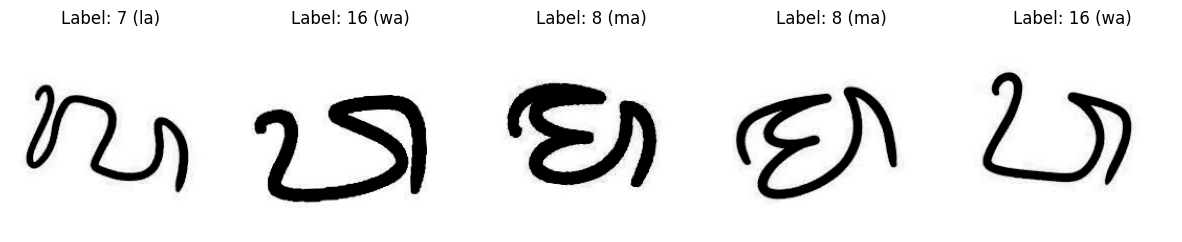

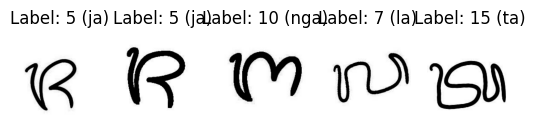

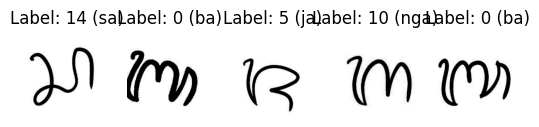

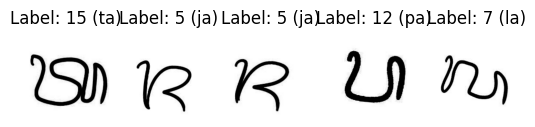

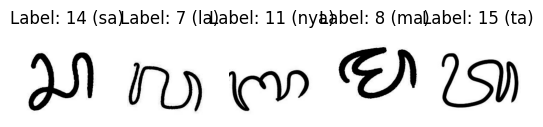

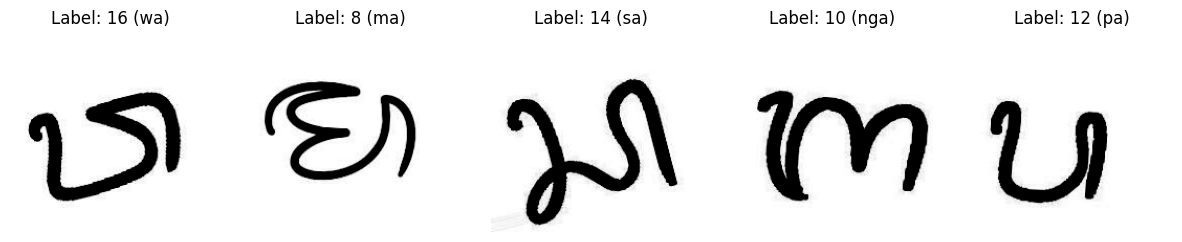

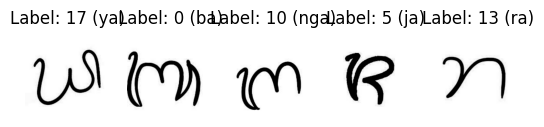

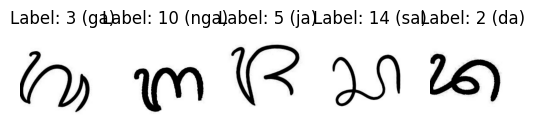

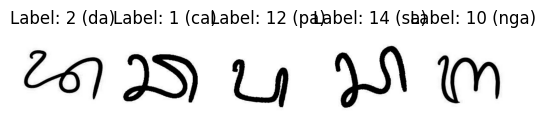

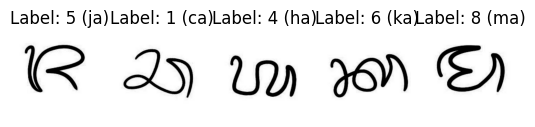

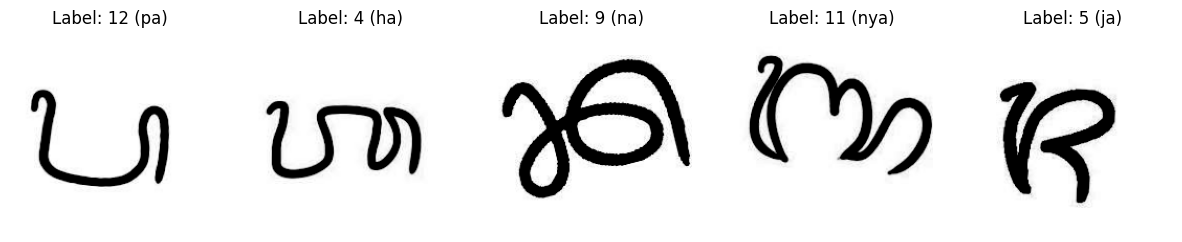

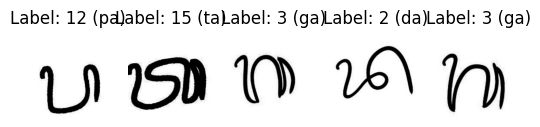

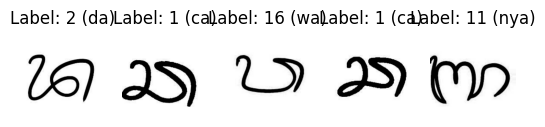

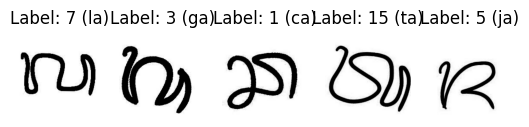

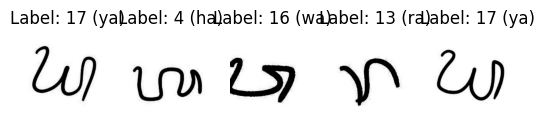

In [ ]:
visualize_data(train_dataset, class_names, num_images=5)
visualize_data(val_dataset, class_names, num_images=5)
visualize_data(test_dataset, class_names, num_images=5)

# Define Model

In [ ]:
def create_model(unfreeze_layers, unfreeze=True):
  # Load the MobileNetV2 model
  # mobilenet_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=IMG_SIZE)
  # if unfreeze:
  #   # Freeze all layers initially
  #   mobilenet_model.trainable = False

  #   # Unfreeze the last 10 layers
  #   for layer in mobilenet_model.layers[-unfreeze_layers:]:
  #       layer.trainable = True
  # else:
  #   mobilenet_model.trainable = False

  # model = tf.keras.Sequential([
  #   mobilenet_model,
  #   tf.keras.layers.GlobalAveragePooling2D(),
  #   tf.keras.layers.Dense(512, activation="relu"),
  #   tf.keras.layers.Dropout(0.5),
  #   # tf.keras.layers.Dense(256, activation="relu"),
  #   # tf.keras.layers.Dropout(0.5),
  #   tf.keras.layers.Dense(NUM_CLASSES, activation="softmax")
  # ])

  model = tf.keras.Sequential([
      tf.keras.layers.Input(shape=IMG_SIZE),
# First convolutional block
    tf.keras.layers.Conv2D(32, (5, 5), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Second convolutional block
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Third convolutional block
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Flatten and dense layers
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
  ])

  return model


In [ ]:
# Define custom callbacks
class EarlyStoppingCallback(tf.keras.callbacks.Callback):

    # Define the correct function signature for on_epoch_end method
    def on_epoch_end(self, epoch, logs=None):
        # Check if the accuracy is greater or equal to 0.95 and validation accuracy is greater or equal to 0.8
        if logs['accuracy'] >= 0.95 and logs['val_accuracy'] >= 0.95:
            self.model.stop_training = True

            print("\nReached 95% train accuracy and 95% validation accuracy, so cancelling training!")

In [ ]:
model = create_model(10, unfreeze=False)
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

<ipython-input-43-7f08d2228391>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=IMG_SIZE)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)                    │ (None, 64, 64, 32)          │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 512)                 │       4,194,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 18)                  │           9,234 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,298,834 (16.40 MB)

 Trainable params: 4,298,834 (16.40 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    steps_per_epoch=total_training_images // BATCH_SIZE
)

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 749ms/step - accuracy: 0.0875 - loss: 3.3521 - val_accuracy: 0.0573 - val_loss: 2.8597
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 743ms/step - accuracy: 0.0751 - loss: 2.8482 - val_accuracy: 0.1032 - val_loss: 2.7291
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 479ms/step - accuracy: 0.1989 - loss: 2.5345 - val_accuracy: 0.4183 - val_loss: 2.0484
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 554ms/step - accuracy: 0.3935 - loss: 2.1888 - val_accuracy: 0.6695 - val_loss: 1.4742
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 741ms/step - accuracy: 0.5843 - loss: 1.4665 - val_accuracy: 0.7861 - val_loss: 0.7818
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 386ms/step - accuracy: 0.7258 - loss: 0.9162 - val_accuracy: 0.8510 - val_loss: 0.6286
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 644ms/step - accuracy: 0.7189 - loss: 0.7641 - val_accuracy: 0.8797 - val_loss: 0.4124
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 394ms/step - accuracy: 0.7770 - loss: 0.7641 - val_accuracy: 0.9284 - val_loss:

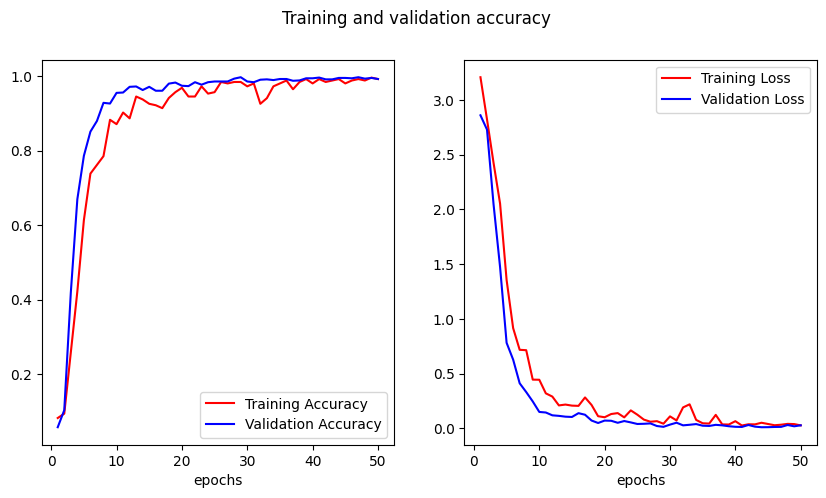

In [ ]:
# Get training and validation accuracies
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(1, len(acc) + 1) # Generate a sequence of numbers from 1 to the number of epochs trained

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Training and validation accuracy')

for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
    ax[i].plot(epochs, data[0], 'r', label="Training " + label)
    ax[i].plot(epochs, data[1], 'b', label="Validation " + label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')

plt.show()

In [ ]:
loss, accuracy = model.evaluate(test_dataset)

print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9960 - loss: 0.0122
Test Loss: 0.009857609868049622
Test Accuracy: 0.9961795806884766


# Save Model

In [ ]:
model.save('classification_model.keras')

In [ ]:
model.save('classification_model_scratch_v3.h5')

In [ ]:
# Convert to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TFLite model
with open("model.tflite", "wb") as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmpqqav6p3x'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name='keras_tensor_1313')
Output Type:
  TensorSpec(shape=(None, 18), dtype=tf.float32, name=None)
Captures:
  135902598213024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135902598300064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135902598303584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135902598301648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135902598305344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135902598302704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135902598304816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135902598305696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135902598299888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135902598307280: TensorSpec(shape=(), dtype=tf.resource, name=None)
